In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%load_ext autoreload
%autoreload 2
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from scipy.spatial import distance


In [2]:
## load points dataset
#Third pepper
def load_points_dataset(f_p):
    with open(f_p,"r") as f:
        all_lines=f.readlines()
    points={}
    i=0
    while(i<len(all_lines)):
        if(i>len(all_lines)):
            break
        line=all_lines[i].split(",")
        label=line[0]
        file=line[3]
        first_point=None
        second_point=None
        #print(i)
        #print(line)
        if label=="head":
            first_point=(int(line[1]),int(line[2]))
        elif label =="tail":
            second_point=(int(line[1]),int(line[2]))
        i+=1
        if(i<len(all_lines)):
            line2=all_lines[i].split(",")
            if line2[3]==file:
                if line2[0]=="head":
                    first_point=(int(line2[1]),int(line2[2]))
                elif line2[0] =="tail":
                    second_point=(int(line2[1]),int(line2[2]))
                i+=1
                #print(line2)
        #print(first_point,second_point)
        if file in points:
            # file already in dictionary append the list
            print(f"Appending the file to existing one {file}")
            points[file].append([first_point,second_point])
        else:
            points[file]=[[first_point,second_point]]
    return points

In [3]:
def get_imagePoints(imgPoints,nz_points):
    mindistances=[]
    for point in imgPoints:
        cpoint_head=None
        cpoint_tail=None
        # very high intitial distances
        dist_tail=12345
        dist_head=12345
        if point is not None and point[0] is not None:
            cpoint_head=min(nz_points,key=lambda c:distance.euclidean(c,point[0]))
            dist_head=distance.euclidean(cpoint_head,point[0])
        if point is not None and point[1] is not None:
            cpoint_tail=min(nz_points,key=lambda c:distance.euclidean(c,point[1]))
            dist_tail=distance.euclidean(cpoint_tail,point[1])
        mindistances.append(dist_tail+dist_head)
    index_min = min(range(len(mindistances)), key=mindistances.__getitem__)
    res=imgPoints[index_min]
    return res

In [4]:
gt_points=load_points_dataset("/media/asad/adas_cv_2/test_kp.csv")

Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg


In [5]:
gt_points

{'0008.jpg': [[(1490, 947), (1320, 551)]],
 '0009.jpg': [[(559, 1205), (710, 632)]],
 '0011.jpg': [[(972, 520), (1369, 986)]],
 '0026.jpg': [[(821, 543), (1312, 884)]],
 '0038.jpg': [[(943, 859), (1274, 437)]],
 '0048.jpg': [[(802, 501), (1374, 697)]],
 '0010.jpg': [[(642, 1112), (625, 732)],
  [(2232, 896), (2766, 970)],
  [(3368, 436), (3305, 959)],
  [(4867, 709), (5049, 1237)],
  [(6190, 732), (5980, 1282)]]}

In [6]:
extensions=[".jpg",".JPEG",".jpg",".jpeg",".png"]
def get_cuc_dicts(img_dir):
    json_files = [json_file for json_file in os.listdir(img_dir) if json_file.endswith(".json")] 
    dataset_dicts = []
    for idx,json_file in enumerate(json_files):
        for ext in extensions:
            filename=json_file.split(".")[0]+ext
            c_fname=os.path.join(img_dir,filename)
            img=cv2.imread(c_fname)
            if img is not None:
                break
        if img is None:
            raise (f"Image Not Found for {json_file}")
        print(f"Processing json {json_file}")
        with open(os.path.join(img_dir,json_file)) as f:
            imgs_anns = json.load(f)
        record = {}      
        height, width = img.shape[:2] 
        record["file_name"] = c_fname
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        annos = imgs_anns["shapes"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            px = [x for x,y in anno]
            py = [y for x,y in anno]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            print("Getting point annotations!!")
            keypoints=get_imagePoints(gt_points[filename],poly)
            ## fix poitns which are none
            if keypoints[0] is not None:
                x1,y1=keypoints[0]
                c1=2
            else:
                x1,y1=0.0,0.0
                c1=1
            if keypoints[0] is not None:
                x2,y2=keypoints[1]
                c2=2
            else:
                x2,y2=0.0,0.0
                c2=1
            poly = [p for x in poly for p in x]
            #print([x1,y1,c1,x2,y2,c2])
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "keypoints": [x1+0.5,y1+0.5,c1,x2+0.5,y2+0.5,c2],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        print(f"Processed images {idx}")
        dataset_dicts.append(record)
    return dataset_dicts


In [7]:
for d in ["train"]:
        DatasetCatalog.register("pep_" + d, lambda d=d: get_cuc_dicts("/media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/one/" + d))
        MetadataCatalog.get("pep_" + d).set(thing_classes=["pep"])
        MetadataCatalog.get("pep_" + d).set(keypoint_names=["head","tail"])
        MetadataCatalog.get("pep_" + d).set(keypoint_flip_map=[("head","head"),("tail","tail")])
        MetadataCatalog.get("pep_" + d).set(keypoint_connection_rules=[("head","tail",(0,255,255))])
        

In [8]:
pep_metadata = MetadataCatalog.get("pep_train")

In [9]:
pep_metadata

namespace(name='pep_train',
          thing_classes=['pep'],
          keypoint_names=['head', 'tail'],
          keypoint_flip_map=[('head', 'head'), ('tail', 'tail')],
          keypoint_connection_rules=[('head', 'tail', (0, 255, 255))])

In [10]:
dataset_dicts = DatasetCatalog.get("pep_train")

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1


In [11]:
def draw_points(datalist,k=1):
    for i in range(k):
        data=datalist[i]
        #print(data)
        ann=data["annotations"]
        fn=data["file_name"]
        img=cv2.imread(fn)
        fig=plt.figure(figsize=(10,10))
        for d in ann:
            kp=d["keypoints"]
            #print(kp)
            x1,y1=int(kp[0]),int(kp[1])
            x2,y2=int(kp[3]),int(kp[4])
            cv2.circle(img,(x1,y1),14,(255,255,0),-1)
            cv2.circle(img,(x2,y2),14,(255,0,255),-1)
        plt.imshow(img[...,::-1])

In [12]:
#dataset_dicts

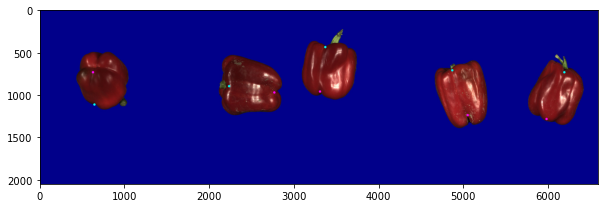

In [13]:
draw_points(dataset_dicts)

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("pep_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS="/media/asad/ADAS_CV/cuc/output_axels2/model_final.pth"
cfg["MODEL"]["ANCHOR_GENERATOR"]["ASPECT_RATIOS"][0]=[0.5,1.0,1.5]
cfg["INPUT"]["RANDOM_FLIP"]="horizontal"
cfg["INPUT"]["ROTATE"]=[-2.0,2.0]
cfg["INPUT"]["LIGHT_SCALE"]=2
cfg["INPUT"]["Brightness_SCALE"]=[0.5,1.5]
cfg["INPUT"]["Contrast_SCALE"]=[0.5,2]
cfg["INPUT"]["Saturation_SCALE"]=[0.5,2]
cfg["MODEL"]["KEYPOINT_ON"]=True
cfg.MODEL['ROI_KEYPOINT_HEAD']["NUM_KEYPOINTS"]=2
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES=1
cfg.MODEL.RETINANET.NUM_CLASSES=1
cfg.OUTPUT_DIR="/media/asad/ADAS_CV/vegs_results/pepper" 

In [15]:
cfg.MODEL.keys()

dict_keys(['LOAD_PROPOSALS', 'MASK_ON', 'KEYPOINT_ON', 'DEVICE', 'META_ARCHITECTURE', 'WEIGHTS', 'PIXEL_MEAN', 'PIXEL_STD', 'BACKBONE', 'FPN', 'PROPOSAL_GENERATOR', 'ANCHOR_GENERATOR', 'RPN', 'ROI_HEADS', 'ROI_BOX_HEAD', 'ROI_BOX_CASCADE_HEAD', 'ROI_MASK_HEAD', 'ROI_KEYPOINT_HEAD', 'SEM_SEG_HEAD', 'PANOPTIC_FPN', 'RETINANET', 'RESNETS'])

[08/23 12:56:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:20 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:20 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:20 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    pep     | 6            |
|            |              |
[08/23 12:56:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensit

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:27 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:27 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:27 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:27 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:33 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:33 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:33 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:33 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:38 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:38 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:38 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:38 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:44 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:44 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:44 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:44 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:49 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:49 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:49 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:49 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:54 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:54 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:54 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:54 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:56:59 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:56:59 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:56:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:56:59 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:56:59 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:05 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:05 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:05 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:05 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:10 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:10 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:10 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:10 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:15 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:15 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:15 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:15 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:21 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:21 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:21 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:21 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:26 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:26 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:26 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:26 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:32 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:32 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:32 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:32 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:37 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:37 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:37 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:37 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:42 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:42 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:42 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:42 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:47 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:47 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:47 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:47 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:52 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:52 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:52 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:52 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:57:58 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:57:58 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:57:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:57:58 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:57:58 d2.data.common]: Serializing 2 elements to byte ten

Processing json 0010.json
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Getting point annotations!!
Processed images 0
Processing json 0048.json
Getting point annotations!!
Processed images 1
[08/23 12:58:04 d2.data.build]: Removed 0 images with no usable annotations. 2 images left.
[08/23 12:58:04 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[08/23 12:58:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomBrightness(intensity_min=0.5, intensity_max=1.5), RandomContrast(intensity_min=0.5, intensity_max=2)]
[08/23 12:58:04 d2.data.build]: Using training sampler TrainingSampler
[08/23 12:58:04 d2.data.common]: Serializing 2 elements to byte ten

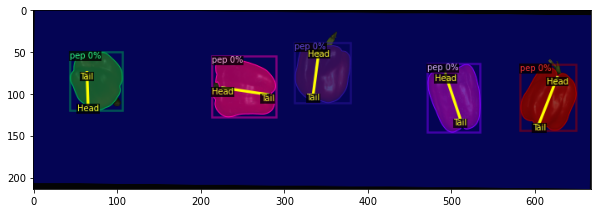

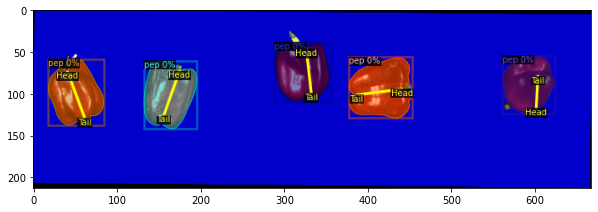

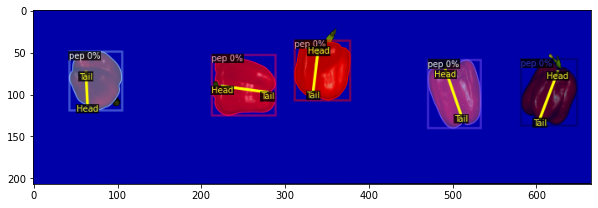

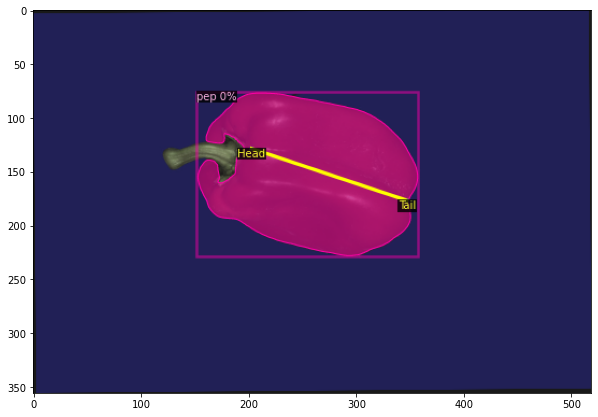

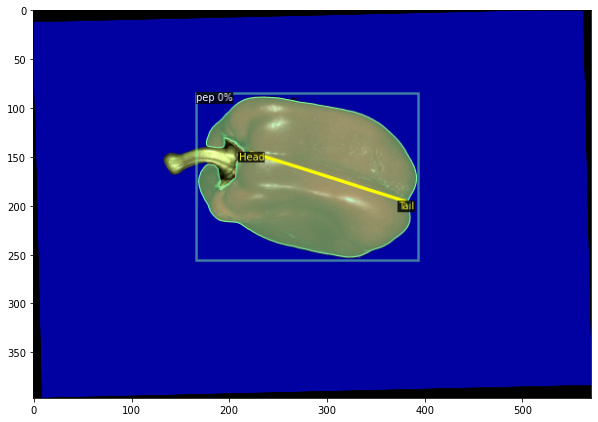

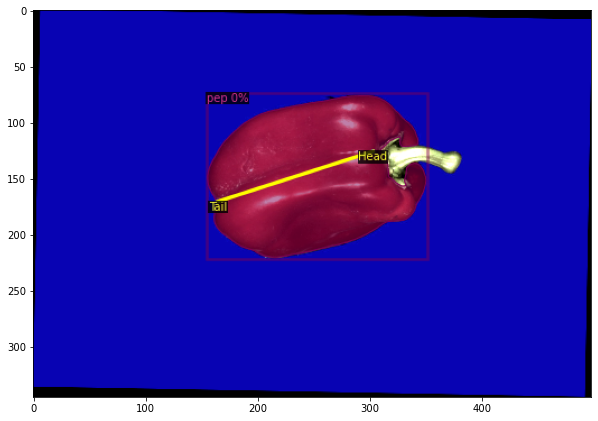

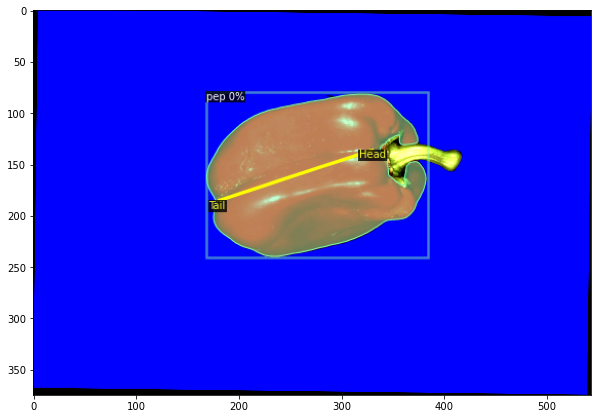

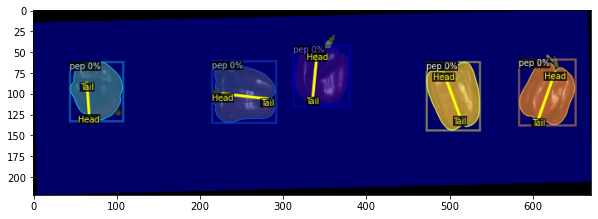

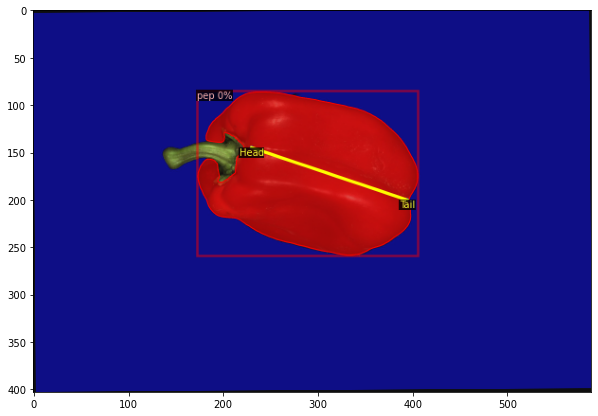

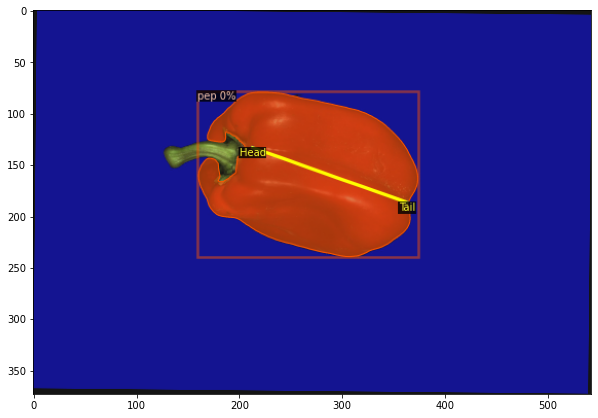

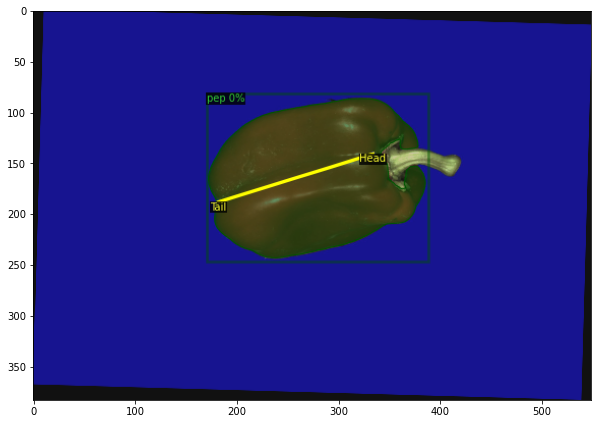

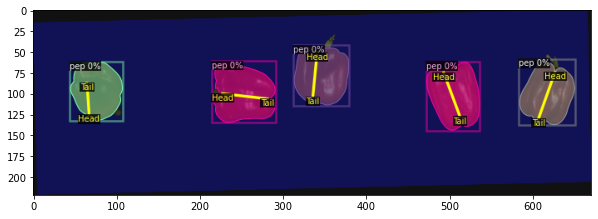

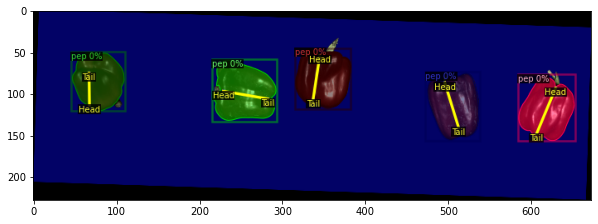

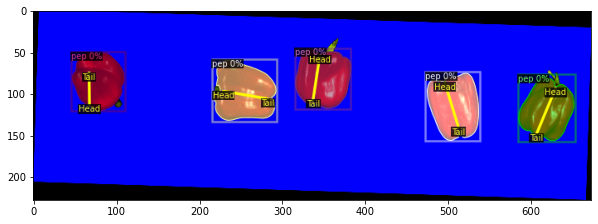

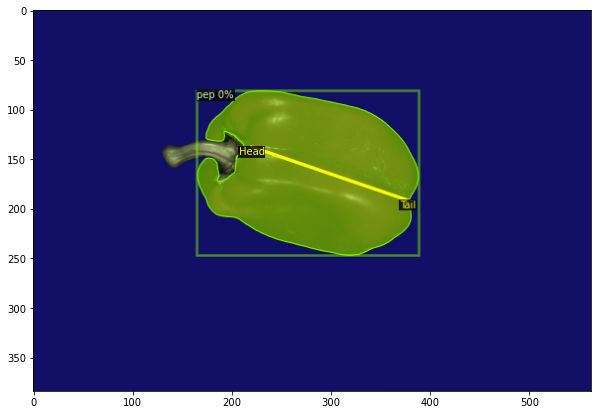

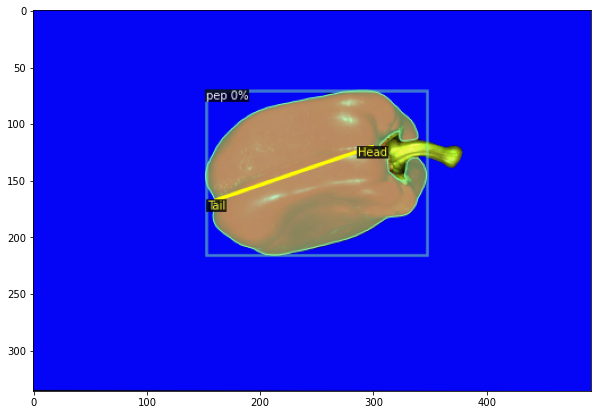

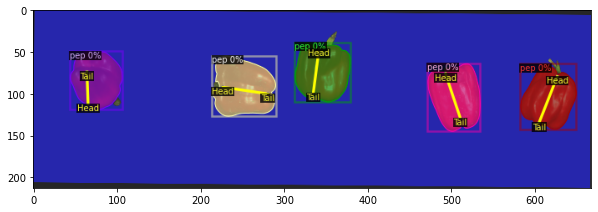

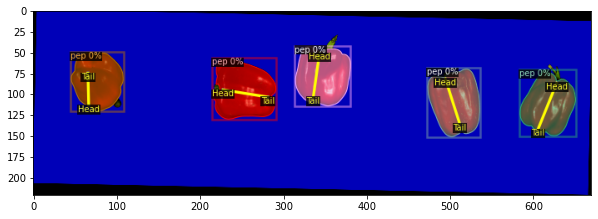

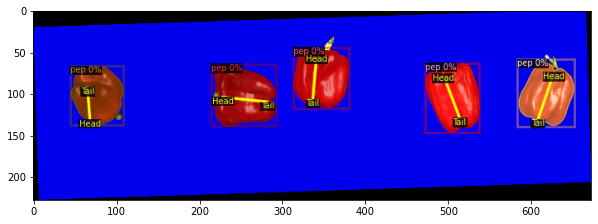

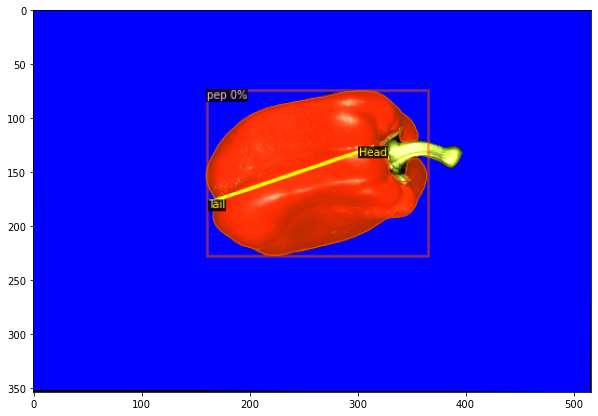

In [17]:
for _ in range(20):
    dd=DefaultTrainer(cfg)
    dl=dd.data_loader
    instance=next(iter(dl))
    #print(f"Instance Gt are {instance}")
    print(f"The image shape is {instance[0]['image'].permute(1,2,0).to('cpu').shape}")
    visualizer = Visualizer(instance[0]["image"].permute(1,2,0).to("cpu").numpy(), metadata=pep_metadata, scale=0.5, instance_mode=ColorMode.SEGMENTATION  )
    
    out = visualizer.draw_dataloader(instance[0]["instances"].to("cpu"))
    plt.figure(figsize = (10,10))
    plt.imshow(out.get_image()[:, :, ::-1])

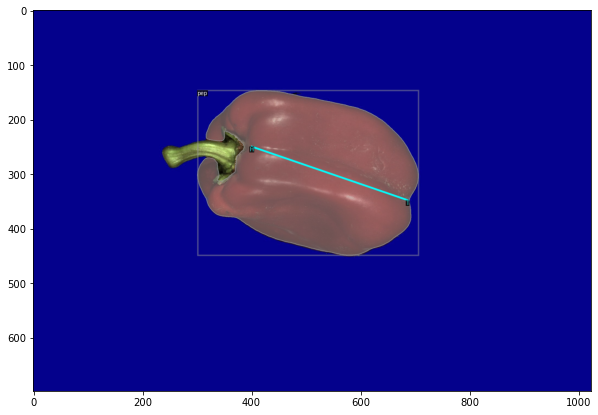

In [17]:
import random
plt.figure(figsize = (10,10))
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pep_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::])